TFs downloaded form [tfcheckpoint](https://www.tfcheckpoint.org/)

In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
data_path = "data/"
check_path = "checkpoints/"
table_path = "tables/"

# os.makedirs(check_path)

os.chdir("../")
print(os.getcwd())

/Users/flynnzhang/CMU/Spring24/02620-ML4Scientists/scRNA-seq_ML


In [3]:
# load all combined data
all_adata = sc.read_h5ad(check_path + 'combined_labeled.h5ad')

all_adata

AnnData object with n_obs × n_vars = 23873 × 19724
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [4]:
all_adata.obs.cell_types.value_counts()

cell_types
immune cells          10372
fibroblasts            9046
epithelial cells       3181
endothelial cells      1039
smooth muscle cell      235
Name: count, dtype: int64

In [5]:
# subset data to only include cells interested in
cell_types_of_interest = ['epithelial cells']
adata_subset = all_adata[all_adata.obs.cell_types.isin(cell_types_of_interest)].copy()

adata_subset

AnnData object with n_obs × n_vars = 3181 × 19724
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

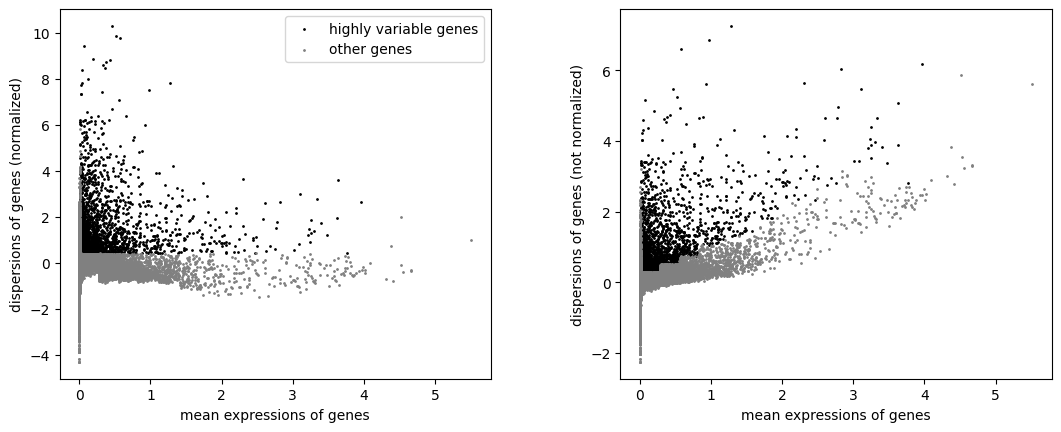

In [6]:
# get the highly variable genes
sc.pp.highly_variable_genes(adata_subset, min_mean=0.01, max_mean=4, min_disp=0.4)
sc.pl.highly_variable_genes(adata_subset)

In [7]:
# subset the data to only include the highly variable genes
filtered_adata = adata_subset[:, adata_subset.var.highly_variable]

filtered_adata

View of AnnData object with n_obs × n_vars = 3181 × 2673
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [8]:
# remove genes with 0 variance
variances = np.var(filtered_adata.X.toarray(), axis=0)
non_zero_variance_mask = variances > 0
filtered_adata = filtered_adata[:, non_zero_variance_mask]

filtered_adata

View of AnnData object with n_obs × n_vars = 3181 × 2673
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [9]:
# use combat to correct for batch effects and rule out unwanted sources of variation
sc.pp.combat(filtered_adata, key='batch', covariates=['total_counts'])

# scale each gene to unit variance, clip values exceeding SD 10
sc.pp.scale(filtered_adata, max_value=10)

/Users/flynnzhang/anaconda3/envs/seq/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/flynnzhang/anaconda3/envs/seq/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Regression

#### List of cell types that are worth exploring:
- Immune cells
- Fibroblasts
- Endothelial cells
- Epithelial cells

In [10]:
# load all tfs
tfs = pd.read_csv(data_path + "TFs/tfs.txt", sep="\t")

tfs

,Gene_symbol,Gene_Name,Synonyms,Human_entrez,Mouse_entrez,Rat_entrez
0,A430033K04Rik,-,-,NaN,243308.0,304336.0
1,AASS,"Alpha-aminoadipic semialdehyde synthase, mitoc...",LORSDH LKRSDH,10157.0,NaN,NaN
2,AATF,Protein AATF,DED CHE-1 CHE1 BFR2,26574.0,56321.0,114512.0
3,ABL1,Tyrosine-protein kinase ABL1,JTK7 c-ABL p150,25.0,11350.0,100909750.0
4,ABRA,Actin-binding Rho-activating protein,STARS,137735.0,223513.0,286965.0
...,...,...,...,...,...,...
3549,ZXDA,Zinc finger X-linked protein ZXDA,ZNF896,7789.0,668166.0,NaN
3550,ZXDB,Zinc finger X-linked protein ZXDB,ZNF905,158586.0,668166.0,NaN
3551,ZXDC,Zinc finger protein ZXDC,MGC11349 FLJ13861,79364.0,80292.0,362399.0
3552,ZYX,Zyxin,-,7791.0,NaN,NaN


In [11]:
# we need mouse tfs
TFs_mouse = tfs[tfs['Mouse_entrez'].notna()]['Gene_symbol'].values
TFs_mouse = [x for x in TFs_mouse if x in filtered_adata.var_names]

print('Total genes:', len(filtered_adata.var_names))
print('Total present TFs:', len(TFs_mouse))

Total genes: 2673
Total present TFs: 8


## OLS and Ridge Regression

In [12]:
# free up some memory
del all_adata
del adata_subset

In [28]:
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(adata, method, tf_list, alphas=[0.01, 0.05, 0.1, 1], n_splits=5, l1_ratio=[0.01, 0.05, 0.1, 0.5, 1]):
    results = {}
    print('Initializing', method, 'regression model with cross-validation...')
    
    scaler = StandardScaler()
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=3, random_state=42)
    
    for tf in tf_list:
        print('Fitting models for', tf)
        
        Y = adata[:, tf].X.flatten()
        X = adata.X[:, ~adata.var_names.isin([tf])]
        X_scaled = scaler.fit_transform(X) if method in ['Ridge', 'Lasso'] else X
        
        if method == 'OLS':
            X_ols = sm.add_constant(X_scaled)
            model = sm.OLS(Y, X_ols)
            result = model.fit()
        elif method == 'Ridge':
            model = RidgeCV(alphas=alphas, cv=rkf, scoring='neg_mean_squared_error')
            result = model.fit(X_scaled, Y)
        elif method == 'Lasso':
            model = LassoCV(alphas=alphas, cv=rkf, random_state=42, max_iter=10000)
            result = model.fit(X_scaled, Y)
        elif method == 'ElasticNet':
            model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=rkf, random_state=42)
            result = model.fit(X_scaled, Y)
        elif method == 'DecisionTree':
            model = DecisionTreeRegressor(random_state=42)
            parameters = {'max_depth': [None, 10, 100], 'min_samples_split': [2, 10, 50]}
            cv_model = GridSearchCV(model, parameters, cv=rkf, scoring='neg_mean_squared_error')
            result = cv_model.fit(X_scaled, Y)
        
        results[tf] = result
        
    return results

def calculate_metrics(adata, results, method):
    metrics = {}
    scaler = StandardScaler()
    
    for tf, model in results.items():
        print(f'Calculating metrics for {tf}')
        Y = adata[:, tf].X.flatten()
        X = adata.X[:, ~adata.var_names.isin([tf])]
        X_scaled = scaler.fit_transform(X) if method in ['Ridge', 'Lasso', 'ElasticNet'] else X
        
        if method in ['Ridge', 'Lasso', 'ElasticNet', 'DecisionTree']:
            predictions = model.predict(X_scaled)
        elif method == 'OLS':
            X_ols = sm.add_constant(X_scaled)
            predictions = model.predict(X_ols)
        
        r2 = r2_score(Y, predictions)
        mse = mean_squared_error(Y, predictions)
        
        metrics[tf] = {"R2": r2, "MSE": mse}
    
    return metrics


In [29]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
filtered_adata

AnnData object with n_obs × n_vars = 3181 × 2673
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [15]:
# OLS model
results_lr = fit_model(filtered_adata, method='OLS', tf_list=TFs_mouse)
metrics_lr = calculate_metrics(filtered_adata, results_lr, method='OLS')

Initializing OLS regression model with cross-validation...
Fitting models for Arhgap22
Fitting models for Basp1
Fitting models for Csprs
Fitting models for Fgf2
Fitting models for Ppp1r15a
Fitting models for Trib2
Fitting models for Vhl
Fitting models for Zfp955a
Calculating metrics for Arhgap22
Calculating metrics for Basp1
Calculating metrics for Csprs
Calculating metrics for Fgf2
Calculating metrics for Ppp1r15a
Calculating metrics for Trib2
Calculating metrics for Vhl
Calculating metrics for Zfp955a


In [17]:
metrics_lr

{'Arhgap22': {'R2': 0.8666673568675015, 'MSE': 0.13329072827163851},
 'Basp1': {'R2': 0.9404633952971221, 'MSE': 0.05951788918695784},
 'Csprs': {'R2': 0.928234195524355, 'MSE': 0.07174324430718183},
 'Fgf2': {'R2': 0.9197427002417032, 'MSE': 0.05500315615308785},
 'Ppp1r15a': {'R2': 0.9407570648513395, 'MSE': 0.059224312571960806},
 'Trib2': {'R2': 0.8724724477491409, 'MSE': 0.12069861367380552},
 'Vhl': {'R2': 0.87608791822406, 'MSE': 0.12256322042972725},
 'Zfp955a': {'R2': 0.8509544992209728, 'MSE': 0.122955412346115}}

In [22]:
# ridge model
alphas = np.logspace(-3, 2, 6)
results_ridge = fit_model(filtered_adata, method='Ridge', tf_list=TFs_mouse, alphas=alphas)
metrics_ridge = calculate_metrics(filtered_adata, results_ridge, method='Ridge')

Initializing Ridge regression model with cross-validation...
Fitting models for Arhgap22
Fitting models for Basp1
Fitting models for Csprs
Fitting models for Fgf2
Fitting models for Ppp1r15a
Fitting models for Trib2
Fitting models for Vhl
Fitting models for Zfp955a
Calculating metrics for Arhgap22
Calculating metrics for Basp1
Calculating metrics for Csprs
Calculating metrics for Fgf2
Calculating metrics for Ppp1r15a
Calculating metrics for Trib2
Calculating metrics for Vhl
Calculating metrics for Zfp955a


In [23]:
metrics_ridge

{'Arhgap22': {'R2': 0.82290506274591, 'MSE': 0.17703925},
 'Basp1': {'R2': 0.9225545565117823, 'MSE': 0.0774211},
 'Csprs': {'R2': 0.9027352296717701, 'MSE': 0.0972342},
 'Fgf2': {'R2': 0.8939637466209946, 'MSE': 0.072670385},
 'Ppp1r15a': {'R2': 0.9222728606181115, 'MSE': 0.0777027},
 'Trib2': {'R2': 0.8301668935133881, 'MSE': 0.16073877},
 'Vhl': {'R2': 0.8331699529496959, 'MSE': 0.165014},
 'Zfp955a': {'R2': 0.804647592806218, 'MSE': 0.1611564}}

In [24]:
# lasso model
alphas = np.logspace(-3, 2, 6)
results_lasso = fit_model(filtered_adata, method='Lasso', tf_list=TFs_mouse, alphas=alphas)
metrics_lasso = calculate_metrics(filtered_adata, results_lasso, method='Lasso')

Initializing Lasso regression model with cross-validation...
Fitting models for Arhgap22
Fitting models for Basp1
Fitting models for Csprs
Fitting models for Fgf2
Fitting models for Ppp1r15a
Fitting models for Trib2
Fitting models for Vhl
Fitting models for Zfp955a
Calculating metrics for Arhgap22
Calculating metrics for Basp1
Calculating metrics for Csprs
Calculating metrics for Fgf2
Calculating metrics for Ppp1r15a
Calculating metrics for Trib2
Calculating metrics for Vhl
Calculating metrics for Zfp955a


In [25]:
metrics_lasso

{'Arhgap22': {'R2': 0.013806289851618136, 'MSE': 0.98588365},
 'Basp1': {'R2': 0.7296786303002838, 'MSE': 0.2702364},
 'Csprs': {'R2': 0.41761297224425176, 'MSE': 0.5822039},
 'Fgf2': {'R2': 0.21768049039353, 'MSE': 0.5361512},
 'Ppp1r15a': {'R2': 0.7275166744324673, 'MSE': 0.27239767},
 'Trib2': {'R2': 0.01281042846054481, 'MSE': 0.9343269},
 'Vhl': {'R2': 0.0, 'MSE': 0.98911434},
 'Zfp955a': {'R2': 0.0, 'MSE': 0.8249522}}

In [20]:
# # elastic net model
# alphas = [0.01, 0.05, 0.1, 1]
# l1_ratio = [0.01, 0.05, 0.1, 0.5, 1]
# results_en = fit_model(filtered_adata, method='ElasticNet', tf_list=TFs_mouse, alphas=alphas, l1_ratio=l1_ratio)
# metrics_en = calculate_metrics(filtered_adata, results_en, method='ElasticNet')

Initializing ElasticNet regression model with cross-validation...
Fitting models for Csprs
Fitting models for Cys1
Fitting models for Fgf2
Fitting models for Rhox5
Fitting models for Trib2
Calculating metrics for Csprs
Calculating metrics for Cys1
Calculating metrics for Fgf2
Calculating metrics for Rhox5
Calculating metrics for Trib2


In [35]:
# decision tree model
results_dt = fit_model(filtered_adata, method='DecisionTree', tf_list=TFs_mouse)
metrics_dt = calculate_metrics(filtered_adata, results_dt, method='DecisionTree')

Initializing DecisionTree regression model with cross-validation...
Fitting models for Arhgap22


In [ ]:
metrics_dt

In [33]:
def save_metrics_to_csv(metrics, filename):
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(metrics, orient='index')
    # Save DataFrame to CSV
    df.to_csv(filename)
    print(f"Data saved to {filename}")

# Save metrics to CSV
save_metrics_to_csv(metrics_lasso, table_path + 'epithelial/metrics_lasso.csv')

Data saved to tables/epithelial/metrics_lasso.csv


## TF-target gene pairs generation

In [44]:
def extract_top_genes_with_weights(results, adata, alpha=0.05, top_percent=0.1):
    sig_genes_info = {}
    for tf, result in results.items():
        gene_names = adata.var_names[~adata.var_names.isin([tf])]  # exclude the TF from the gene list
        p_values = result.pvalues[1:]  # exclude the constant term's p-value
        coeffs = result.params[1:]  # exclude the constant term's coefficient

        # extract significant genes
        sig_mask = p_values < alpha
        sig_genes = gene_names[sig_mask]
        sig_p_values = p_values[sig_mask]
        sig_coeffs = coeffs[sig_mask]

        # convert to DataFrame
        significant_df = pd.DataFrame({
            'Gene': sig_genes,
            'Coefficient': sig_coeffs,
            'P-Value': sig_p_values
        })

        # filter by top percentage of absolute coefficients
        significant_df['Abs_Coefficient'] = significant_df['Coefficient'].abs()
        threshold = significant_df['Abs_Coefficient'].quantile(1 - top_percent)  # Calculate the threshold for top percentage
        top_genes_df = significant_df[significant_df['Abs_Coefficient'] >= threshold]

        # store the results
        sig_genes_info[tf] = top_genes_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

    return sig_genes_info

sig_top_genes = extract_top_genes_with_weights(OLS_res, filtered_adata, alpha=0.05, top_percent=1)

In [46]:
sig_top_genes

{'Csprs':         Gene  Coefficient   P-Value
 52    Clec4e     5.283233  0.009476
 50     Cntn4    -4.612144  0.030081
 104     Lcp2     3.026117  0.045199
 106   Adra1b     2.649588  0.001555
 141    Ms4a2     2.143081  0.018327
 ..       ...          ...       ...
 125     Rnd1     0.124893  0.041448
 80     Rasa3     0.124363  0.041252
 139     Mbd1     0.123529  0.038034
 117  Gm10263    -0.121921  0.046480
 127   Acvrl1    -0.117392  0.037489
 
 [145 rows x 3 columns],
 'Cys1':               Gene  Coefficient   P-Value
 100            Cd4    -7.038826  0.038434
 229         Gm5416     6.519049  0.037909
 174          Timd4    -5.284561  0.010595
 251          Ms4a2    -0.971811  0.006183
 23           Kcna4    -0.769958  0.042570
 ..             ...          ...       ...
 26   1110034G24Rik    -0.051700  0.039685
 164         Entpd3    -0.051410  0.045544
 199           Glrx    -0.050675  0.035961
 237  1600002H07Rik     0.049161  0.037433
 33            Pim2     0.048881  0.047

In [38]:
# make df to store results
res_df = pd.DataFrame(index=TFs_mouse, columns=['r-squared', 'mse'])
res_df['r-squared'] = [OLS_res[tf].rsquared for tf in OLS_res.keys()]
res_df['mse'] = [OLS_res[tf].mse_resid for tf in OLS_res.keys()]

res_df

,r-squared,mse
Csprs,0.978103,0.504577
Cys1,0.982587,0.077560
Fgf2,0.982222,0.280850
Rhox5,0.997265,0.004160
Trib2,0.972126,0.608020


In [39]:
# save OLS results, significant genes & weights, and model performance
import pickle

for tf, df in sig_top_genes.items():
    df.to_csv(table_path + 'sig_top_genes_' + tf + '.csv')

res_df.to_csv(table_path + 'ols_results.csv')

with open(check_path + 'ols_results.pkl', 'wb') as f:
    pickle.dump(OLS_res, f)


## Important regulons for bladder cancer

In [50]:
# read mut genes of bladder cancer
blad_genes = pd.read_csv(data_path + "mut_genes/blad_cancer_genes.csv")

blad_genes

,Gene,Freq
0,Tp53,0.517
1,Ttn,0.327
2,Kmt2d,0.293
3,Arid1a,0.268
4,Kdm6a,0.262
...,...,...
16387,Commd2,0.002
16388,Galt,0.002
16389,Commd7,0.002
16390,Or1f1,0.002


#### From TFs to genes

Genes related to bladder cancer are obtained form [TCGA or MSK-IMPACT sequencing study](https://www.cbioportal.org/study/summary?id=blca_msk_tcga_2020)

In [71]:
# see if TFs we found are in the blad_genes
key_tfs = blad_genes[blad_genes['Gene'].isin(sig_top_genes.keys())]

key_tfs

,Gene,Freq
8568,Trib2,0.006


In [72]:
targ_regulated = {}
for tf, df in sig_top_genes.items():
    if tf in key_tfs['Gene'].values:
        targ_regulated[tf] = df

targ_regulated

{'Trib2':         Gene  Coefficient   P-Value
 86   Cyp4f18   -10.028013  0.022885
 81    Cd209a     9.690804  0.021631
 62      Cd37    -5.280767  0.023036
 9       Mrc1     3.442799  0.006102
 24   Pcdh11x    -1.799847  0.003887
 ..       ...          ...       ...
 150    Lynx1     0.145310  0.041160
 60    Gm9844     0.144592  0.035553
 137  Gm10320     0.140766  0.035252
 64    Klhl25    -0.140101  0.032054
 134     Glrx     0.136536  0.043687
 
 [177 rows x 3 columns]}

In [60]:
# # see if blad_genes are present in the significant genes
# for tf, df in sig_top_genes.items():
#     print(tf, df[df['Gene'].isin(blad_genes['Gene'])])

In [62]:
# # see significant target mutated genes that are potentially regulated by key tfs in bladder cancer
# mut_targ_regulated = {}
# for tf, df in sig_top_genes.items():
#     if tf in key_tfs['Gene'].values:
#         mut_targ_regulated[tf] = df[df['Gene'].isin(blad_genes['Gene'])]

# mut_targ_regulated

{'Trib2':         Gene  Coefficient   P-Value
 62      Cd37    -5.280767  0.023036
 9       Mrc1     3.442799  0.006102
 24   Pcdh11x    -1.799847  0.003887
 76   Col13a1     1.687548  0.045965
 29     Kcnn3     0.975186  0.048888
 ..       ...          ...       ...
 146      Ghr    -0.151232  0.043309
 120  Slc43a2     0.148779  0.026520
 19     Ndrg3    -0.147231  0.029152
 150    Lynx1     0.145310  0.041160
 64    Klhl25    -0.140101  0.032054
 
 [124 rows x 3 columns]}